# Clean tweets. Remove emojis and punctuations

In [3]:
amazon$Tweets<- iconv(amazon$Tweets, from = "UTF-8", to = "ASCII", sub = "")
amazon$Tweets <- removePunctuation(amazon$Tweets)

In [4]:
#make a corpus 
amazon_corpus <- VCorpus(VectorSource(amazon$Tweets))

In [23]:
clean_corpus <- function(cleaned_corpus){
    removeURL <- content_transformer(function(x) gsub("(f|ht)tp(s?)://\\S+", "", x, perl=T))
    cleaned_corpus <- tm_map(cleaned_corpus, removeURL)
    cleaned_corpus <- tm_map(cleaned_corpus, content_transformer(replace_abbreviation))
    cleaned_corpus <- tm_map(cleaned_corpus, content_transformer(tolower))
    cleaned_corpus <- tm_map(cleaned_corpus, removePunctuation)
    cleaned_corpus <- tm_map(cleaned_corpus, removeNumbers)
    cleaned_corpus <- tm_map(cleaned_corpus, removeWords, stopwords("english"))
    custom_stop_words <- c("amazon", "amazons","don", "t")
    cleaned_corpus <- tm_map(cleaned_corpus, removeWords, custom_stop_words)
    cleaned_corpus <- tm_map(cleaned_corpus, stripWhitespace)
    return(cleaned_corpus)
}

In [24]:
amazon_clean_corpus <- clean_corpus(amazon_corpus)

# TDM

In [26]:
TDM_amazon <- TermDocumentMatrix(amazon_clean_corpus)
TDM_amazon_m <- as.matrix(TDM_amazon)

In [76]:
term_frequency <- rowSums(TDM_amazon_m)
term_frequency <- sort(term_frequency,dec=TRUE)

# UNI-GRAM WORD CLOUD

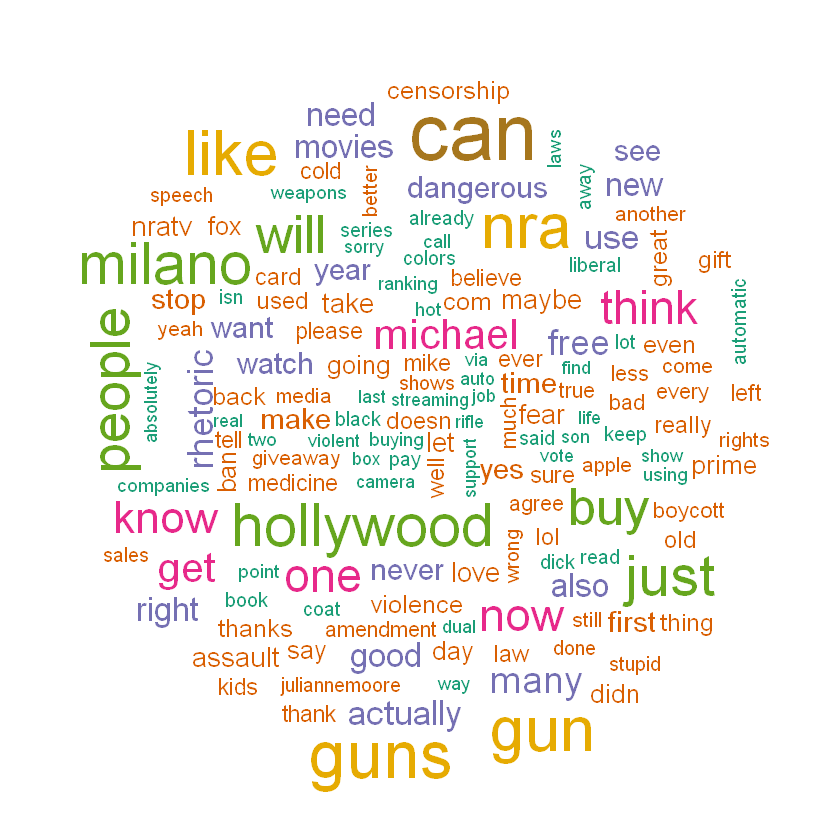

In [28]:
word_freqs <- data.frame(term = names(term_frequency), num = term_frequency)
tempwcld<-wordcloud(word_freqs$term, word_freqs$num,min.freq=10, max.words=300,colors=brewer.pal(7, "Dark2"))

# BI-GRAMS

In [29]:
tokenizer <- function(x)
NGramTokenizer(x,Weka_control(min=2,max=2))
bigram_tdm <- TermDocumentMatrix(amazon_clean_corpus,control = list(tokenize=tokenizer))
bigram_tdm_m <- as.matrix(bigram_tdm)
term_frequency <- rowSums(bigram_tdm_m)
term_frequency <- sort(term_frequency,dec=TRUE)
word_freqs <- data.frame(term = names(term_frequency), num = term_frequency)

Warning message in wordcloud(word_freqs$term, word_freqs$num, min.freq = 2, max.words = 60, :
"card giveaway could not be fit on page. It will not be plotted."Warning message in wordcloud(word_freqs$term, word_freqs$num, min.freq = 2, max.words = 60, :
"buy cold could not be fit on page. It will not be plotted."

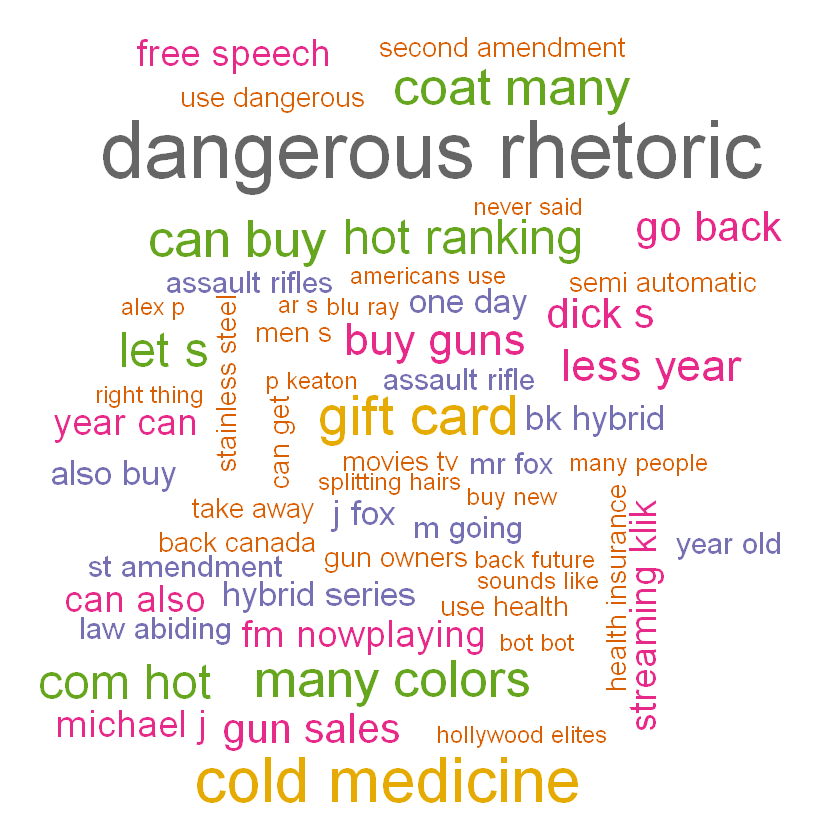

In [33]:
wordcloud(word_freqs$term, word_freqs$num,min.freq=2,max.words=60, colors=brewer.pal(8, "Dark2"))

# TRI-GRAMS

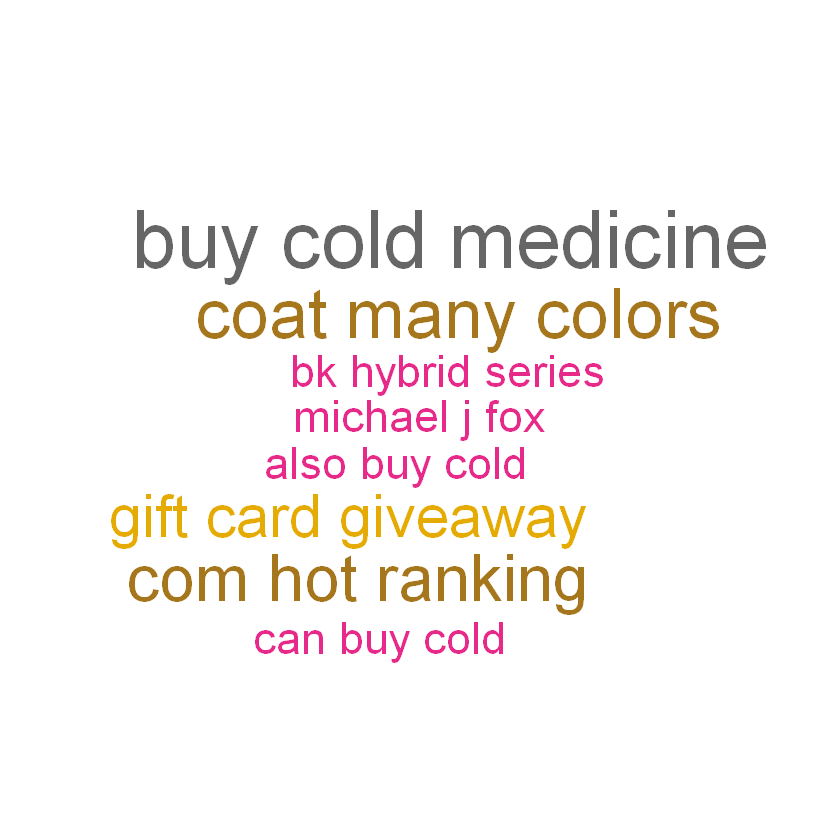

In [37]:
tokenizer <- function(x)
NGramTokenizer(x,Weka_control(min=3,max=3))
bigram_tdm <- TermDocumentMatrix(amazon_clean_corpus,control = list(tokenize=tokenizer))
bigram_tdm_m <- as.matrix(bigram_tdm)
term_frequency <- rowSums(bigram_tdm_m)
term_frequency <- sort(term_frequency,dec=TRUE)
word_freqs <- data.frame(term = names(term_frequency), num = term_frequency)
wordcloud(word_freqs$term, word_freqs$num,min.freq=7,max.words=50, colors=brewer.pal(8, "Dark2"))

# WORD CLOUD: TF-IDF

Warning message in weighting(x):
"empty document(s): 5 11 16 39 53 54 61 63 64 70 71 75 77 90 95 148 150 183 184 191 194 202 210 211 218 328 362 394 428 590 597 663 672 818 853 960 978 1024 1096 1098 1103 1134 1206 1227 1673 1996"

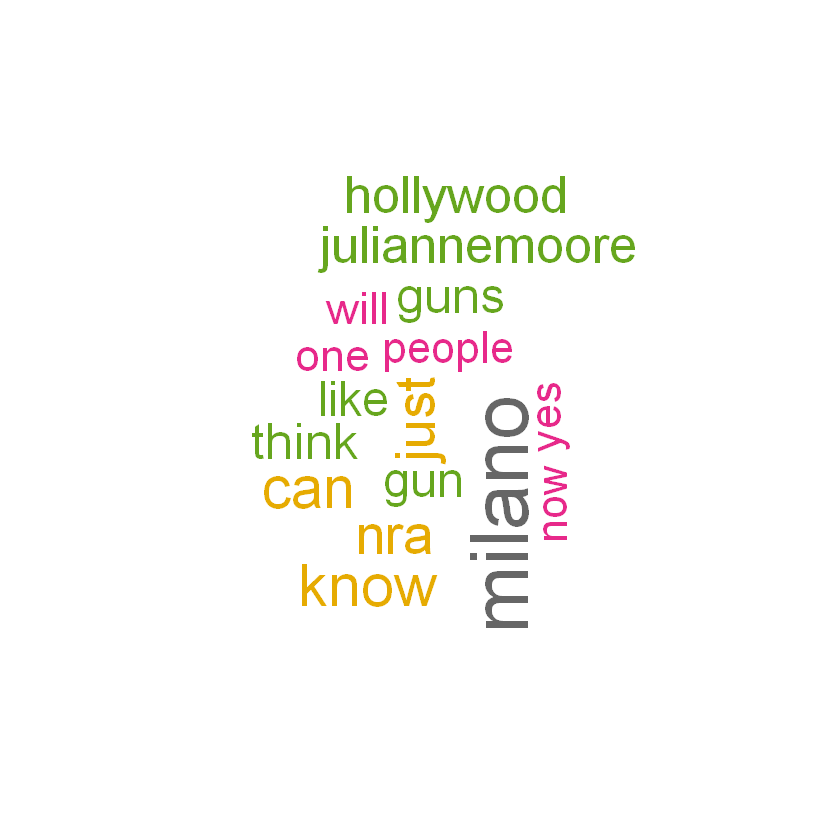

In [38]:
tfidf_tdm <- TermDocumentMatrix(amazon_clean_corpus, control=list(weighting=weightTfIdf))
tfidf_tdm_m <- as.matrix(tfidf_tdm)
term_frequency <- rowSums(tfidf_tdm_m)
term_frequency <- sort(term_frequency,dec=TRUE)
word_freqs <- data.frame(term = names(term_frequency), num = term_frequency)
wordcloud(word_freqs$term, word_freqs$num,min.freq=50, max.words=150,colors=brewer.pal(8, "Dark2"))

# SENTIMENT ANALYSIS 

In [39]:
(ampolarity<- polarity(amazon$Tweets))
amazon$sentiment<- ampolarity$all$polarity

all,wc,polarity,pos.words,neg.words,text.var
all,4,0.0000000,-,-,The Manics new album
all,11,0.5427204,nice,-,Straight out of the box it is a very nice quality
all,1,0.0000000,-,-,https
all,16,0.0000000,-,-,Didn t Amazon already rule out almost all of the Southern cities that applied I recall
all,1,0.0000000,-,-,B
all,11,-0.3015113,free,"leak , twist",Nomader Collapsible Water Bottle Leak Proof Twist Cap BPA Free oz
all,10,-0.9486833,-,"shake, loss , shake",SlimFast Original Meal Replacement Shake Mix Powder Weight Loss Shake
all,10,0.3162278,sweet,-,Sweet Sweat Stick oz Helps increase circulation sweating and motivatio
all,13,0.2773501,success,-,The Sermon on the Mount The Key to Success in Life Christ Jesus
all,11,0.0000000,-,-,HARMAN Fireplace Fan Blade Single Paddle Acc I P I Universal


In [40]:
amznpos = length(which(amazon$sentiment > 0))
amznneg = length(which(amazon$sentiment <= 0))

In [41]:
amznpos

[1] 432

In [42]:
amznneg

[1] 1581

In [44]:
# Use bing lexicon
bing_lex <- get_sentiments("bing")
amzn_t <- tidy(TDM_amazon)

In [45]:
amazon_bing_lex <- inner_join(amzn_t, bing_lex, by = c("term" = "word"))
table(amazon_bing_lex$sentiment)


negative positive 
     683      631 

In [46]:
amazon_bing_lex$sentiment_n <- ifelse(amazon_bing_lex$sentiment=="negative", -1, 1)
amazon_bing_lex$sentiment_value <- amazon_bing_lex$sentiment_n * amazon_bing_lex$count

In [47]:
amazon_agg <- aggregate(amazon_bing_lex$sentiment_value, list(index = amazon_bing_lex$document), sum)
sapply(amazon_agg,typeof)
amazon_agg$index <- as.numeric(amazon_agg$index)

index           x 
"character"    "double"

In [ ]:
#Multiple Plots

`geom_smooth()` using method = 'loess'


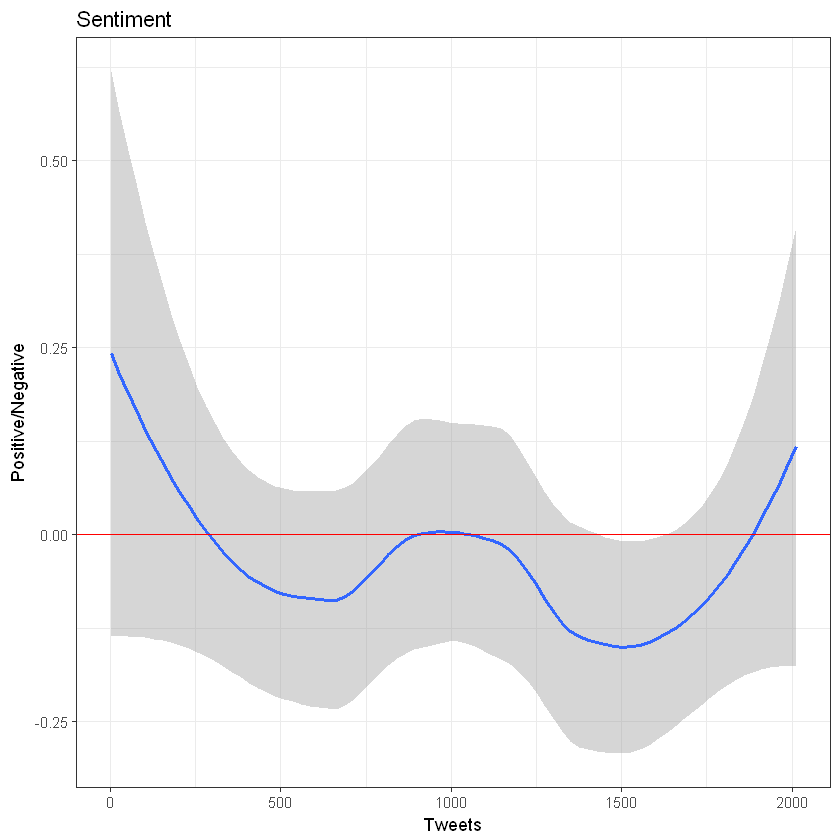

In [77]:
ggplot(amazon_agg, aes(index, x)) + geom_smooth() + theme_bw()+geom_hline(yintercept = 0, color = "red")+xlab("Tweets")+ylab("Positive/Negative")+ggtitle("Sentiment")

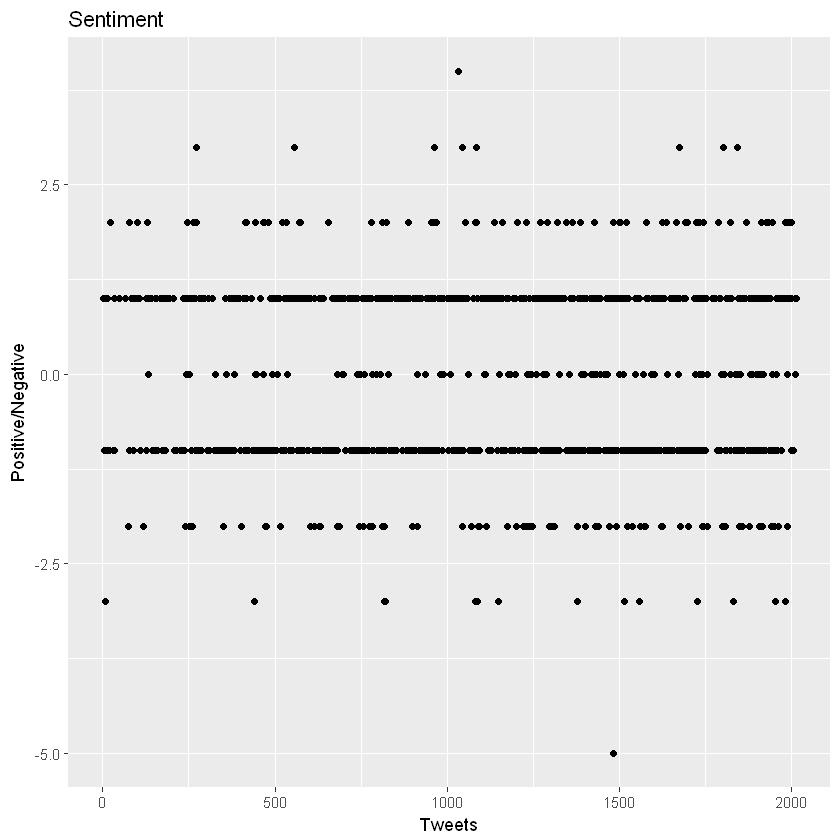

In [78]:
ggplot(amazon_agg, aes(index, x)) + geom_point() +xlab("Tweets")+ylab("Positive/Negative")+ggtitle("Sentiment")

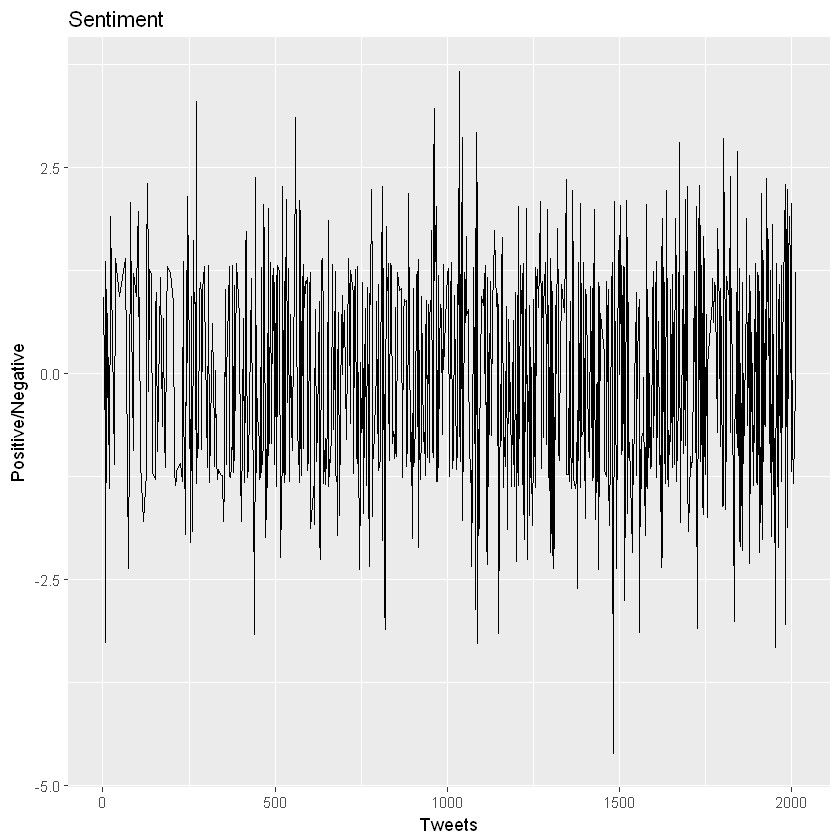

In [79]:
ggplot(amazon_agg, aes(index, x)) + geom_line(position="jitter")+xlab("Tweets")+ylab("Positive/Negative")+ggtitle("Sentiment")

# COMMONALITY CLOUD

In [50]:
dfpos <- amazon[amazon[ , 2] > 0.0, ]
dfneg <- amazon[amazon[ , 2] <= 0.0, ]

In [65]:
postext<- paste(unlist(dfpos$Tweets), collapse =" ")
negtext<- paste(unlist(dfneg$Tweets), collapse =" ")
posnegtext <- c(postext,negtext)
posneg_corpus <- VCorpus(VectorSource(posnegtext))
cleaned_posneg_corpus <- clean_corpus(posneg_corpus)

In [66]:
TDM_posneg <- TermDocumentMatrix(cleaned_posneg_corpus)
TDM_posneg_m <- as.matrix(TDM_posneg)
term_frequency <- rowSums(TDM_posneg_m)
term_frequency <- sort(term_frequency,dec=TRUE)
word_freqs <- data.frame(term = names(term_frequency), num = term_frequency)

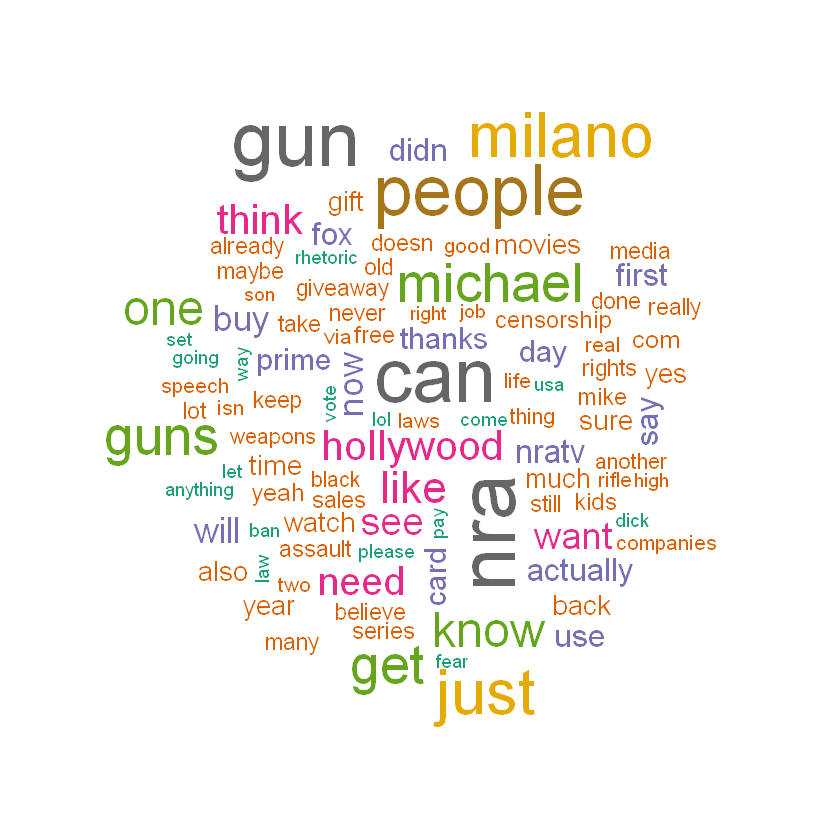

In [68]:
commonality.cloud(TDM_posneg_m,colors=brewer.pal(8, "Dark2"),max.words = 100)

# COMPARISON CLOUD 

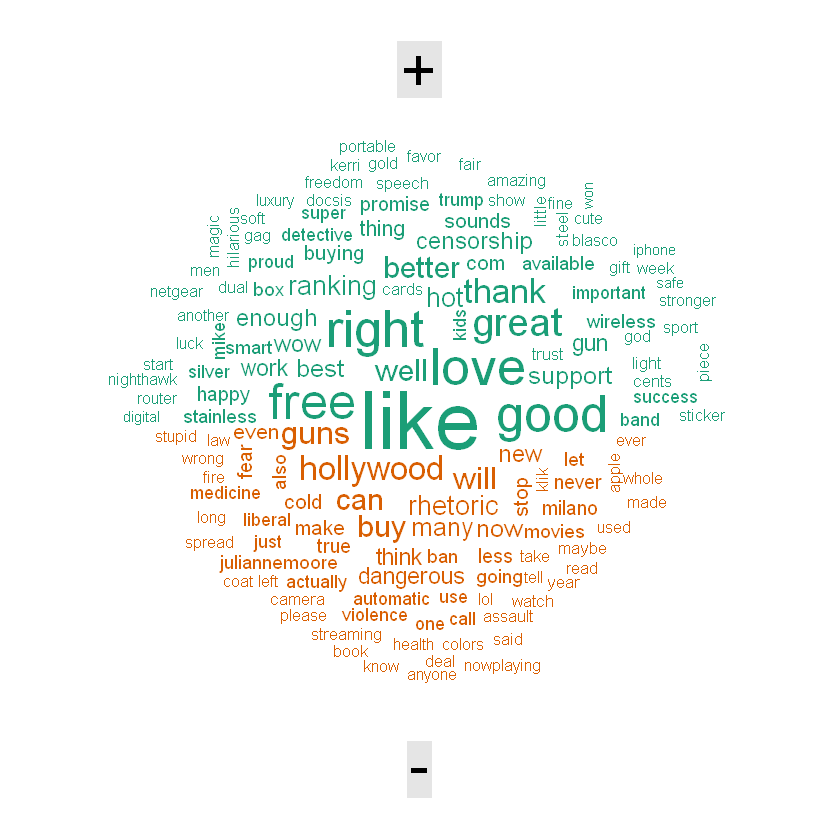

In [71]:
colnames(TDM_posneg) <- c("+","-")
TDM_posneg_m <- as.matrix(TDM_posneg)
comparison.cloud(TDM_posneg_m,colors=brewer.pal(8, "Dark2"),max.words = 150)

# EMOTIONAL RADAR CHART

In [72]:
TDM_tweets <- TermDocumentMatrix(amazon_clean_corpus)
amzn_t <- tidy(TDM_tweets)
nrc_lex <- get_sentiments("nrc")

In [73]:
amzn_nrc <- inner_join(amzn_t, nrc_lex, by = c("term" = "word"))
amzn_nrc_noposneg <- amzn_nrc[!(amzn_nrc$sentiment %in% c("positive","negative")),]

In [74]:
amzn_agg <- aggregate(amzn_nrc_noposneg$count, list(index = amzn_nrc_noposneg$sentiment), sum)

In [75]:
chartJSRadar(amzn_agg)

HTML widgets cannot be represented in plain text (need html)